In [9]:
from tsai.all import *

# Rede Inception

In [10]:
# Helper to shortcut for residual blocks, don't do anything
def noop(x: torch.Tensor) -> torch.Tensor:
    return x

# class ReLU(nn.Module):
#     """ ReLU Activation Function
#     """
#     def __init__(self):
#         super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return nn.functional.relu(x)

class InceptionModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: Tuple[int, int, int] = [7, 5, 3], bottleneck: bool = True) -> None:
        """ Inception Module to apply parallel convolution on time series.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (Tuple[int, int, int], optional): Number of kernels. Defaults to [7, 5, 3].
            bottleneck (bool, optional): If apply a bottleneck layer to convert the number of channels to the correct shape. Defaults to True.
        """
        super().__init__()

        self.kernel_sizes = kernel_size
        # Only apply bottleneck if the input channels number is bigger than 1
        bottleneck = bottleneck if in_channels > 1 else False
        self.bottleneck = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False, padding='same') if bottleneck else noop
        # Calculate and apply convolutions for each kernel size
        self.convolutions = nn.ModuleList([
            nn.Conv1d(out_channels if bottleneck else in_channels, out_channels, kernel_size=k, padding='same', bias=False) for k in self.kernel_sizes
        ])
        # Max Convolutional Pooling layer
        self.maxconv = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), nn.Conv1d(in_channels, out_channels, 1, bias=False, padding='same')])
        self.batchnorm = nn.BatchNorm1d(out_channels * 4)
        self.activation = ReLU() # We just have to modify this activation between ReLU and LeakySineLU

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print('foward-M', x.shape)
        x_ = x
        x = self.bottleneck(x)
        # Conv1, Conv2, Conv3, MaxConv
        x = torch.cat([conv(x) for conv in self.convolutions] + [self.maxconv(x_)], dim=1)
        return self.activation(x)


class InceptionBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, residual: bool = True, depth: int = 6) -> None:
        super().__init__()
        self.residual = residual
        self.depth = depth

        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            # Build each inception module
            self.inception.append(InceptionModule(
                in_channels=(in_channels if d == 0 else out_channels * 4), out_channels=out_channels,
            ))
            if self.residual and d % 3 == 2:
                c_in, c_out = in_channels if d == 2 else out_channels * 4, out_channels * 4
                self.shortcut.append(
                    nn.BatchNorm1d(c_in) if c_in == c_out else nn.Sequential(*[nn.Conv1d(c_in, c_out, kernel_size=1, padding='same'), nn.BatchNorm1d(c_out)])
                )
        self.activation = ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print('foward-b', x.shape)
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2:
               res = x = self.activation(x + self.shortcut[d // 3](res))
        return x


class InceptionTime(nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, sequence_len: int, class_num: int) -> None:
        super().__init__()
        self.inception_block = InceptionBlock(in_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels * 4, class_num)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print('foward-Icpt', x.shape)
        x = self.inception_block(x)
        x = torch.mean(x, dim=-1)
        return self.relu(self.fc(x))

In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile

# Carregando os dados

In [22]:
path = r"data/"

In [23]:
test = pd.read_csv(path+'Metadata_Test.csv')
test.head(2)

,FileName,Class
0,acoustic-guitar-logo-13084.wav,Sound_Guiatr
1,guitar-chords-70663.wav,Sound_Guiatr


In [131]:
train = pd.read_csv(path+'Metadata_Train.csv')
train.head(2)

,FileName,Class
0,1-E1-Major 00.wav,Sound_Guitar
1,1-E1-Major 01.wav,Sound_Guitar


In [133]:
classes = list(train['Class'].value_counts().index)
classes

['Sound_Guitar', 'Sound_Drum', 'Sound_Violin', 'Sound_Piano']

# Distribuição dos dados

In [134]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2)

# TEST plot
fig.add_trace(go.Bar(x=classes, y=test['Class'].value_counts(), name='Test Data'), row=1, col=1)

# TRAIN plot
fig.add_trace(go.Bar(x=classes, y=train['Class'].value_counts(), name='Train Data'), row=1, col=2)

# layout
fig.update_layout(title_text='Class Distribution', height=400, width=800)
fig.update_traces(marker_line_width=0)
fig.show()

# Exemplo spectograma

In [145]:
# Escolhendo um arquivo para cada exmplo
file_example_dict = {}
for cls in classes:
    file_name = train.loc[train['Class'] == cls, 'FileName'].values[0]
    file_example_dict[cls] = file_name
file_example_dict

{'Sound_Guitar': '1-E1-Major 00.wav',
 'Sound_Drum': '04-47367.wav',
 'Sound_Violin': '04-47367.wav',
 'Sound_Piano': '029500_morning-rain-piano-65875.wav'}

In [178]:
def plot_example(file_example_dict, cls):
    # Spectogram
    y, sr = librosa.load(path+'Train_submission/'+file_example_dict[cls])
    spec = np.abs(librosa.stft(y, hop_length=512,))
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
    
    # Spectogram Plot
    plt.colorbar(format='%+2.0f dB');
    plt.title(f'Spectrogram ({cls})');
    plot.show()

## Guitar

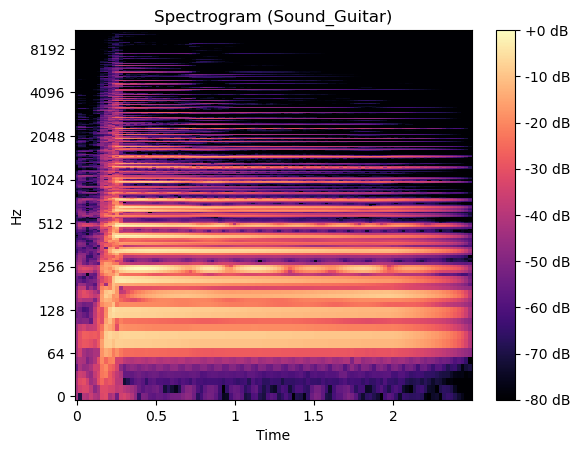

In [153]:
plot_spectrogram_example(file_example_dict, classes[0])

## Drum

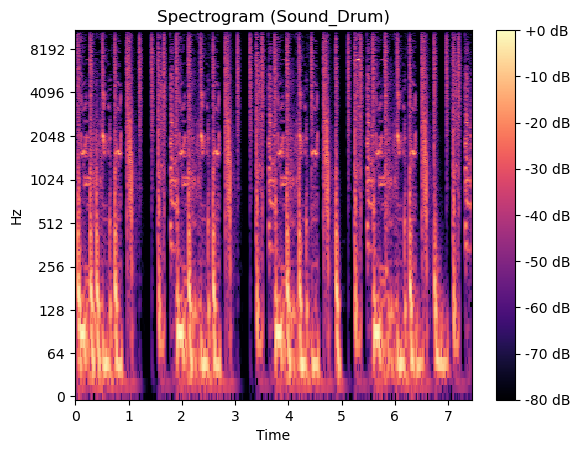

In [149]:
plot_spectrogram_example(file_example_dict, classes[1])

## Violin

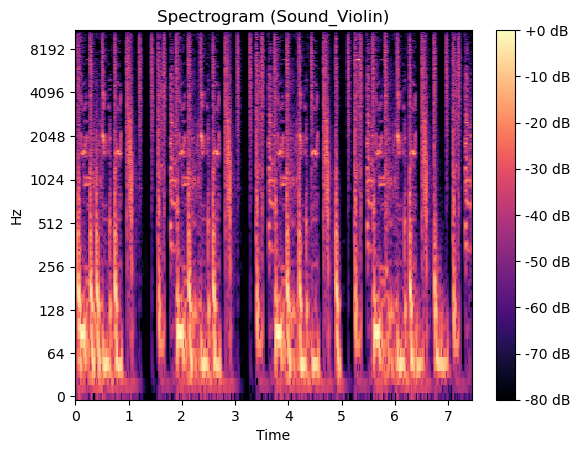

In [150]:
plot_spectrogram_example(file_example_dict, classes[2])

## Piano

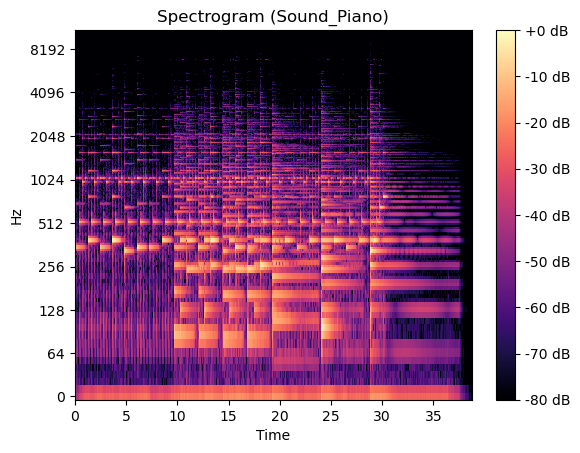

In [151]:
plot_spectrogram_example(file_example_dict, classes[3])

# Normalized mel

In [180]:
import librosa

def get_mel_spectrogram(file_path, max_padding=0, n_fft=2048, hop_length=512, n_mels=128):
    try:
        # Load audio file
        y, sr = librosa.load(file_path)

        # Normalize audio data between -1 and 1
        normalized_y = librosa.util.normalize(y)

        # Generate mel scaled filterbanks
        mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)

        # Convert sound intensity to log amplitude:
        mel_db = librosa.amplitude_to_db(abs(mel))

        # Normalize between -1 and 1
        normalized_mel = librosa.util.normalize(mel_db)

        # Should we require padding
        shape = normalized_mel.shape[1]
        if (max_padding > 0 & shape < max_padding):
            xDiff = max_padding - shape
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            normalized_mel = np.pad(normalized_mel, pad_width=((0,0), (xLeft, xRight)), mode='constant')

    except Exception as e:
        print("Error parsing wavefile: ", e)
        return None 
    return normalized_mel

# Treinando a rede

In [18]:
path = 'C:/Users/andre/1JUPYTER/MineiracaoDados'

In [ ]:
tfms=[None, TSRegression()]
batch_tfms = TSStandardize(by_sample=True, by_var=True) # Padronizando
splits = get_splits(y, valid_size=.2, stratify=True, random_state=42, shuffle=True) # Data split igual para todos
dls = get_ts_dls(X,y,splits=splits,tfms=tfms, batch_tfms=batch_tfms) # Dataloaders
model = InceptionTime(dls.vars, 32, dls.len, dls.c) # Rede Neural
learn = ts_learner(dls, model, metrics=[mae, rmse], cbs=[ShowGraph(), PredictionDynamics(alpha=.5, size=75)]) # Learner: usar MAE e RMSE, com grafico de loss e grafico Y_true Y_pred
learn.fit_one_cycle(300, 3e-4) # 300 epocas e lr de 3e-4
# learn.save_all(path=f'ReLU_{data}_{i}', dls_fname='dls', model_fname='InceptionTime', learner_fname='learner') # Salvando o modelo